# CS598 LHO Project Team 66

Yifei Kang ([yifeik3@illinois.edu](mailto:yifeik3@illinois.edu))

Yunliang Huang ([yh64@illinois.edu](mailto:yh64@illinois.edu))

Mingqing Teng ([mt52@illinois.edu](mailto:mt52@illinois.edu))

# File location
Code and model in the project is stored at

https://drive.google.com/drive/folders/18YGUtUewaJ3trvGwKA2sjLiG6krldnX_?usp=drive_link

# GitHub Repo
https://github.com/yunlianghuang2023/DL4H_Team_66

# Video link
https://mediaspace.illinois.edu/media/t/1_5xh66lq4

## Grading rubric
https://docs.google.com/document/d/1ftHUFl_eeZNfRYLNI0jh-v8tvkQfvSz-q8jzt2026k8/edit#heading=h.3znysh7

# Introduction
In this project, we're trying to reproduce the paper "BEHRT: Transformer for Electronic Health Records" (1). In the orignial paper, BEHRT is A deep neural sequence transduction model for electronic health records (EHR), capable of simultaneously predicting the likelihood of 301 conditions in one's future visits.

##   Background of the problem

Recent advancements in deep learning (DL) have significantly advanced personalized predictions in various medical fields. These developments align with the goals of precision healthcare, which seeks to enhance care provision through precise and personalized prediction, prevention, and intervention strategies. Early applications of DL to EHR data (2) overlooked its nuances, such as irregular inter-visit intervals and temporal event order. To address this, Deepr (3), a convolutional neural network (CNN) model; DeepCare (4), an LSTM architecture with an attention mechanism; and RETAIN (5), an end-to-end RNN model were developed. They outperform most existing models and establishing a robust baseline for EHR learning research.
In this project, we hope to apply recent advancements in DL and natural language processing (NLP), particularly Transformer architecture, we aim to improve prediction accuracy for future diagnoses in electronic health records (EHR). And reproduce the model BEHRT (i.e., BERT for EHR) created by the original authors (1).

The general problem of using a given patient's past EHR to predict their future diagnoses, presented as a multi-label classification problem. Specifically, this involves concurrently predicting the probability of each potential disease, and a single predictive model that scales across a range of diseases.
Modeling EHR has four primary challenges:
*  managing intricate and nonlinear relationships among past, present, and future concepts
* addressing long-term dependencies among concepts, such as diseases manifesting early in a patient's history impacting events significantly later in the future
* grappling with the representation of diverse heterogeneous concepts of varying sizes and forms within the model
* accommodating irregular intervals between consecutive visits

The the state of the art methods Deepr has a APS from 0.360 to 0.393, with AUROC from 0.942 to 0.943; whereas RETAIN has a APS from 0.382 to 0.417, with AUROC from 0.921 to 0.928.

##   Paper explanation

The paper propose that by applying NLP like Transformer on EHR data, the prediction accuracy will increase.

The BEHRT model is built upon to architectural similarities that it has with (and the original inspirations that came from) BERT (6), one of the most powerful Transformer-based architectures in NLP.

In the paper, BEHRT shows a striking improvement of 8.0–13.2% (in terms of average precision scores for different tasks), over the existing state-of-the-art deep EHR models (Deepr and RETAIN). BEHRT has a APS from 0.462 to 0.525, with AUROC from 0.954 to 0.958.

## Ablation

In order to evaluate the performance of model, we will confirm the accuracy of model in a classfication question. Using the textual data note (symptoms, diagnoses, treatments, etc.) to generate diagnose code.

# Scope of Reproducibility:

1.   Hypothesis 1: the prediction accuracy will be good for the current data
* For this Hypothesis, we will calculate the accuracy based on the diagnose note and the actual results

2.   Hypothesis 2: the prediction accuracy will increase for the next visit (T1)
* For this Hypothesis, we will calculate the accuracy based on the the training data on the next visit (T1)

# Methodology

Import packages needed

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import pickle
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Data

###  Data Source
  In this project, we use MIMIC III (7) which is available to us. Description of dataset can be found at https://mimic.mit.edu/docs/iii/tables/. Here we selected the following tables to process:
  * The **d_icd_diagnoses** table: This table defines International Classification of Diseases Version 9 (ICD-9) codes for diagnoses. These codes are assigned at the end of the patient’s stay and are used by the hospital to bill for care provided. Number of rows: 14,567. https://mimic.mit.edu/docs/iii/tables/d_icd_diagnoses/.
  * The **patients** table: This table defines each SUBJECT_ID in the database, i.e. defines a single patient. Number of rows: 46,520. https://mimic.mit.edu/docs/iii/tables/patients/
  * The **admissions** table: This table defines a patient’s hospital admission, HADM_ID. Number of rows: 58,976. https://mimic.mit.edu/docs/iii/tables/admissions/
  * The **diagnoses_icd** table: Contains ICD diagnoses for patients, most notably ICD-9 diagnoses. Number of rows: 651,047. https://mimic.mit.edu/docs/iii/tables/diagnoses_icd/
  * The **noteevents** table: Contains all notes for patients. Number of rows: 2,083,180. https://mimic.mit.edu/docs/iii/tables/noteevents/

The raw data folder has the data we needed for this project. It is located at: https://drive.google.com/drive/folders/1qVO_DpaECCxrPvhi-e25Sng1kvyM5Yvg?usp=drive_link


###  Data Load
* The **vocab** table: made from the *d_icd_diagnoses* table
  * create a map/dict using `ICD9_CODE` and `SHORT_TITLE` as key:value pairs
* The **data**: created from *patients*, *admissions*, and *diagnoses_icd*
  * In *patients*, select
    * `SUBJECT_ID` as `pid` for patient id, unique id for patients
    * `DOB` for date of birth,
    * `GENDER` if needed

  * In *admissions*, select
    * `HADM_ID` as `vid` for visit id, it is unique for each visit, and one patient can have multiple visits
    * `SUBJECT_ID` as `pid` for patient id that matches with *patients* table,
    * `ADMITTIME` represents the the date and time the patient was admitted to the hospital, this is used to calcuate the age of the patient in combination with `DOB` from *patients* table
    * `DIAGNOSIS` that is a preliminary, free text diagnosis for the patient on hospital admission. The diagnosis is usually assigned by the admitting clinician and does not use a systematic ontology. The diagnoses can be very informative (e.g. chronic kidney failure) or quite vague (e.g. weakness). Final diagnoses for a patient’s hospital stay are coded on discharge and can be found in the *DIAGNOSES_ICD* table. This could be the input text.

  * In *diagnoses_icd*, select
    * `HADM_ID` as `vid` for visit id, that is linked with *admissions*
    * `SUBJECT_ID` as `pid` for patient id, that is linked to *patients*
    * `ICD9_CODE` that serves as the output for diagnosis, and can be used in the **vocab** table above

#### Data load function
* The **vocab** table is made by the `token2idx_make.ipynb` with output file `vocab_token_idx.pkl`
	* It contains the `ICD9_CODE` and `DIAGNOSIS`
* The **data** table is made by the `Make_data_parquet_file.ipynb` with output file `data.parquet`
	* It has columns `SUBJECT_ID`,`ICD9_CODE`,`age` with each visit seperated by `SEP`, age of each visit, and total visit times

#### Diagnosis code classification
 Use *noteevents* and *diagnoses_icd* to generate classification.


### Data Processing
We process data both for classification and for BERT




### ICD code classification
For classfication of ICD code, we use *noteevents* and *diagnoses_icd* to generate classification. Codes from V,E,U,8,9 can be exclude in a purpose of facturation as they are not take in count for the calculus of hospitalization fees. Then we selected the most frequent chapters. At last, we create one dataframe for selected diagnoses with merge with texts on HADM_ID, and the other one for selected chapters, and concatenate them to have the final dataframe that will be use for prediction.

Code to run this can be found at https://drive.google.com/file/d/1jNJ9WAWFXuain1o6q65SiLlxTV4yGecK/view?usp=drive_link

#### Data preparation for automated text classification for ICD 9 diagnosis code

Load data

In [2]:
!pwd

/content


In [3]:
%cd '/content/drive/MyDrive/CS598_DHL_Project_Team66/data/raw_data'

/content/drive/MyDrive/CS598_DHL_Project_Team66/data/raw_data


In [4]:
NOTEEVENTS=pd.read_csv('./NOTEEVENTS.csv',dtype={'ROW_ID':np.int32, 'SUBJECT_ID': np.int32,'HADM_ID': np.float64,
                                       'CHARTDATE':str,'STORETIME':str,'CHARTTIME':str,
                                       'STORETIME': str,'CATEGORY': str,'DESCRIPTION':str,'CGID':str,'ISERROR':str,
                                        'TEXT':str}, parse_dates=['CHARTDATE'])
DIAGNOSES_ICD=pd.read_csv('./DIAGNOSES_ICD.csv',dtype={'ROW_ID':np.int32, 'SUBJECT_ID': np.int32,'HADM_ID': np.int32,
                                            'SEQ_NUM':  np.float64,'ICD9_CODE':str})

Explore NOTEEVENTS

In [5]:
NOTEEVENTS.count()

ROW_ID         2083180
SUBJECT_ID     2083180
HADM_ID        1851344
CHARTDATE      2083180
CHARTTIME      1766614
STORETIME      1246404
CATEGORY       2083180
DESCRIPTION    2083180
CGID           1246404
ISERROR            886
TEXT           2083180
dtype: int64

In [6]:
NOTEEVENTS.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [7]:
NOTEEVENTS.groupby('CATEGORY').count()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,DESCRIPTION,CGID,ISERROR,TEXT
CATEGORY,,,,,,,,,,
Case Management,967,967,954,967,967,967,967,967,14,967
Consult,98,98,98,98,98,98,98,98,0,98
Discharge summary,59652,59652,59652,59652,0,0,59652,0,0,59652
ECG,209051,209051,138190,209051,0,0,209051,0,0,209051
Echo,45794,45794,34037,45794,0,0,45794,0,0,45794
General,8301,8301,8209,8301,8260,8301,8301,8301,65,8301
Nursing,223556,223556,220758,223556,222172,223556,223556,223556,374,223556
Nursing/other,822497,822497,821258,822497,822497,822497,822497,822497,0,822497
Nutrition,9418,9418,9378,9418,9411,9418,9418,9418,18,9418


Explore DIAGNOSES_ICD

In [8]:
DIAGNOSES_ICD['ICD9_CODE']=DIAGNOSES_ICD['ICD9_CODE'].str.pad(4,'left','0')
DIAGNOSES_ICD['ICD9_CHAP']=DIAGNOSES_ICD['ICD9_CODE'].str.slice(0,3)
DIAGNOSES_ICD.count()

ROW_ID        651047
SUBJECT_ID    651047
HADM_ID       651047
SEQ_NUM       651000
ICD9_CODE     651000
ICD9_CHAP     651000
dtype: int64

In [9]:
DIAGNOSES_ICD.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD9_CHAP
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,0486,048
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


In [10]:
##Explore by the first character
DIAGNOSES_ICD.groupby(DIAGNOSES_ICD['ICD9_CODE'].str.slice(0,1))['HADM_ID'].count()

ICD9_CODE
0     42765
1     12322
2    106309
3     38668
4    142137
5     91067
6      6989
7     71110
8     15112
9     27606
E     22544
V     74371
Name: HADM_ID, dtype: int64

Codes from V,E,U,8,9 can be exclude in a purpose of facturation as they are not take in count for the calculus of hospitalization fees.

In [11]:
DIAGNOSES_ICD=DIAGNOSES_ICD[~DIAGNOSES_ICD['ICD9_CODE'].str.slice(0,1).isin(['V','E','U','8','9'])]

Exploration of diagnoses to choose the perfect y
Selection of the most frequent codes

In [12]:
a=DIAGNOSES_ICD.groupby('ICD9_CODE')['HADM_ID'].count().sort_values(ascending=False)

<Axes: >

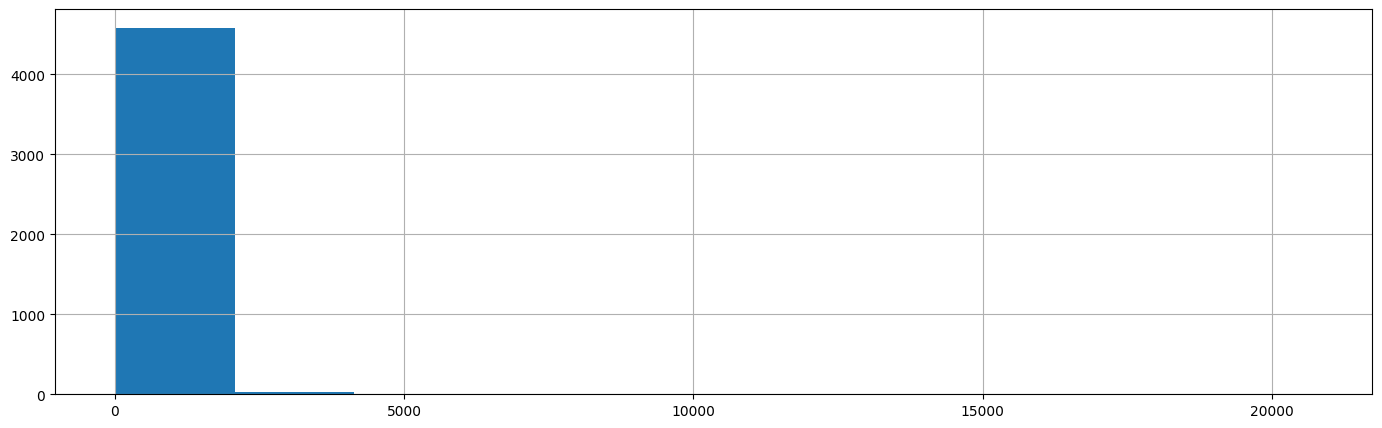

In [13]:
a.hist(figsize= (17, 5))

<Axes: >

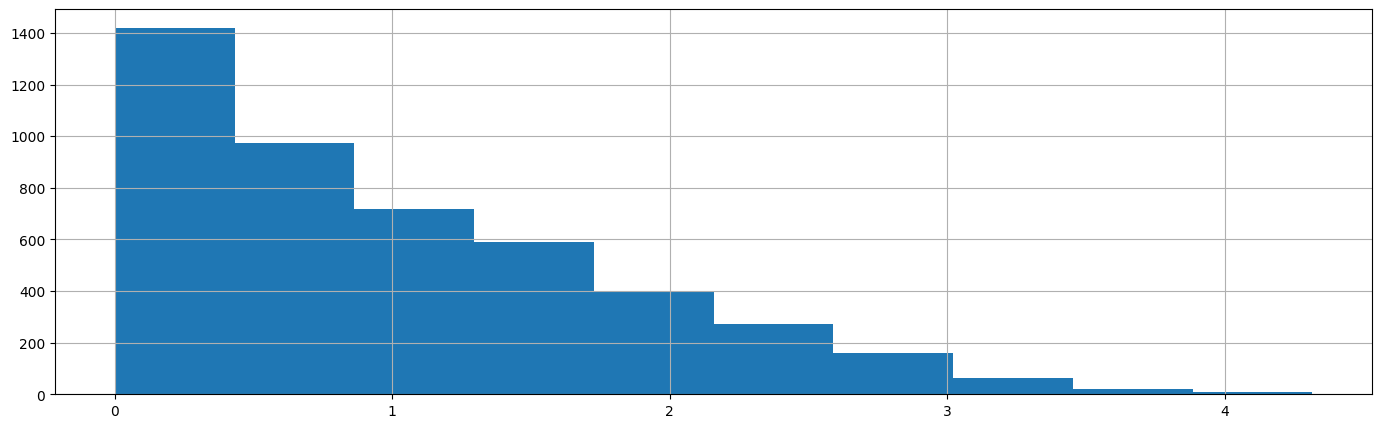

In [14]:
np.log10(a).hist(figsize= (17, 5))

Due to dispersion of the distribution and the low frequency of some code, for the machine learning task a selection of the code and their chapter will be made

In [15]:
print('Nb codes > 1000 occurences= '+str(len(a[a>1000]))+
      '  \nNb codes 1000-100 occurences = ' +str(len(a[(a<1000)&(a>100)]))
      +'  \nNb codes <100 occurences = ' +str(len(a[a<100])) )

Nb codes > 1000 occurences= 98  
Nb codes 1000-100 occurences = 557  
Nb codes <100 occurences = 3970


<Axes: xlabel='ICD9_CODE'>

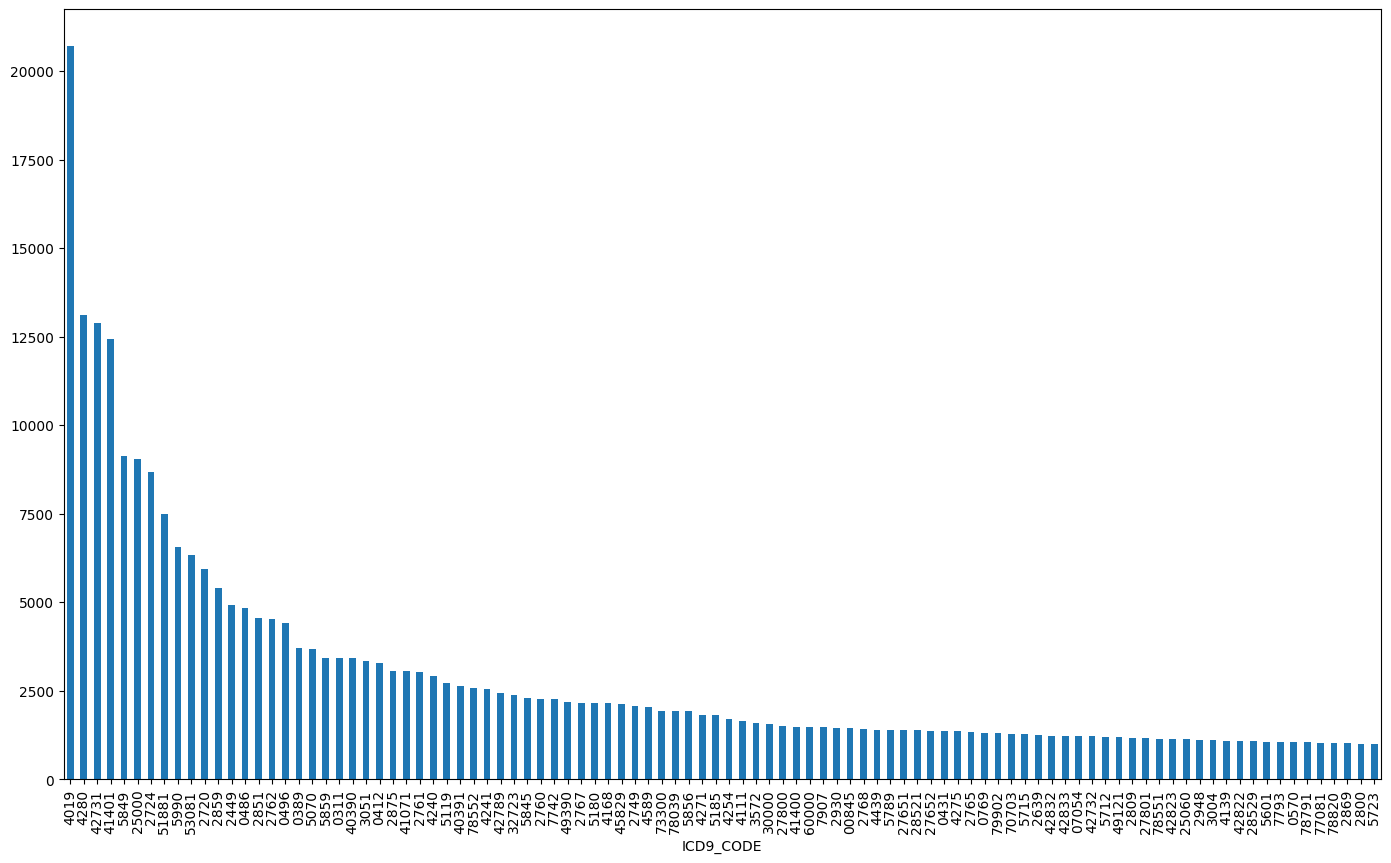

In [16]:
a[a>1000].plot(kind='bar',figsize= (17, 10))

In [17]:
a=DIAGNOSES_ICD.groupby('ICD9_CODE')[ 'HADM_ID'].count()
DIAGNOSES_ICD_freq=DIAGNOSES_ICD[DIAGNOSES_ICD['ICD9_CODE'].isin(a[a>1000].keys())]
df=DIAGNOSES_ICD_freq.groupby('HADM_ID')['ICD9_CODE'].apply(lambda x: "['%s']" %"','".join(x))
df=df.apply(lambda x : eval(x))
DIAGNOSES_ICD_freq=pd.DataFrame(df)
DIAGNOSES_ICD_freq['HADM_ID']=df.keys()
DIAGNOSES_ICD_freq.head()

,ICD9_CODE,HADM_ID
HADM_ID,,
100001,"[5849, 40390]",100001
100003,"[2851, 07054, 5715, 4019]",100003
100006,"[51881, 0486, 2761]",100006
100007,"[0486, 4019]",100007
100009,"[41401, 25000, 27800, 4111, 2859, 4019, 2720]",100009


Selection of stays with the most frequent codes.

In [18]:
print('Number of selected stays = '+str(DIAGNOSES_ICD_freq['HADM_ID'].nunique())+
      '  \nNumber of different codes = ' +str(len(a[a>1000])))

Number of selected stays = 51300  
Number of different codes = 98


Selection of the most frequent chapters

In [19]:
a=DIAGNOSES_ICD.groupby('ICD9_CHAP')[ 'HADM_ID'].count().sort_values(ascending=False)

In [20]:
print('Number of chapter codes > 1000 occurences= '+str(len(a[a>1000]))+
      '  \nNumber of chapter codes 1000-100 occurences = ' +str(len(a[(a<1000)&(a>100)]))
      +'  \nNumber of chapter codes <100 occurences = ' +str(len(a[a<100])) )

Number of chapter codes > 1000 occurences= 109  
Number of chapter codes 1000-100 occurences = 201  
Number of chapter codes <100 occurences = 315


In [21]:
#a=DIAGNOSES_ICD[~DIAGNOSES_ICD['ICD9_CODE'].isin(DIAGNOSES_ICD_freq['ICD9_CODE'])].groupby('ICD9_CHAP')[ 'HADM_ID'].count()
a=DIAGNOSES_ICD.groupby('ICD9_CHAP')['HADM_ID'].count()
DIAGNOSES_ICD_chap_freq=DIAGNOSES_ICD[DIAGNOSES_ICD['ICD9_CHAP'].isin(a[a>1000].keys())]

Selection of stays with the codes belonging to the most frequent ones.

In [22]:
print('Number of selected stays = '+str(DIAGNOSES_ICD_chap_freq['HADM_ID'].nunique())+
      '  \nNumber of different chapters = ' +str(DIAGNOSES_ICD_chap_freq['ICD9_CHAP'].nunique()))

Number of selected stays = 54903  
Number of different chapters = 109


<Axes: xlabel='ICD9_CHAP'>

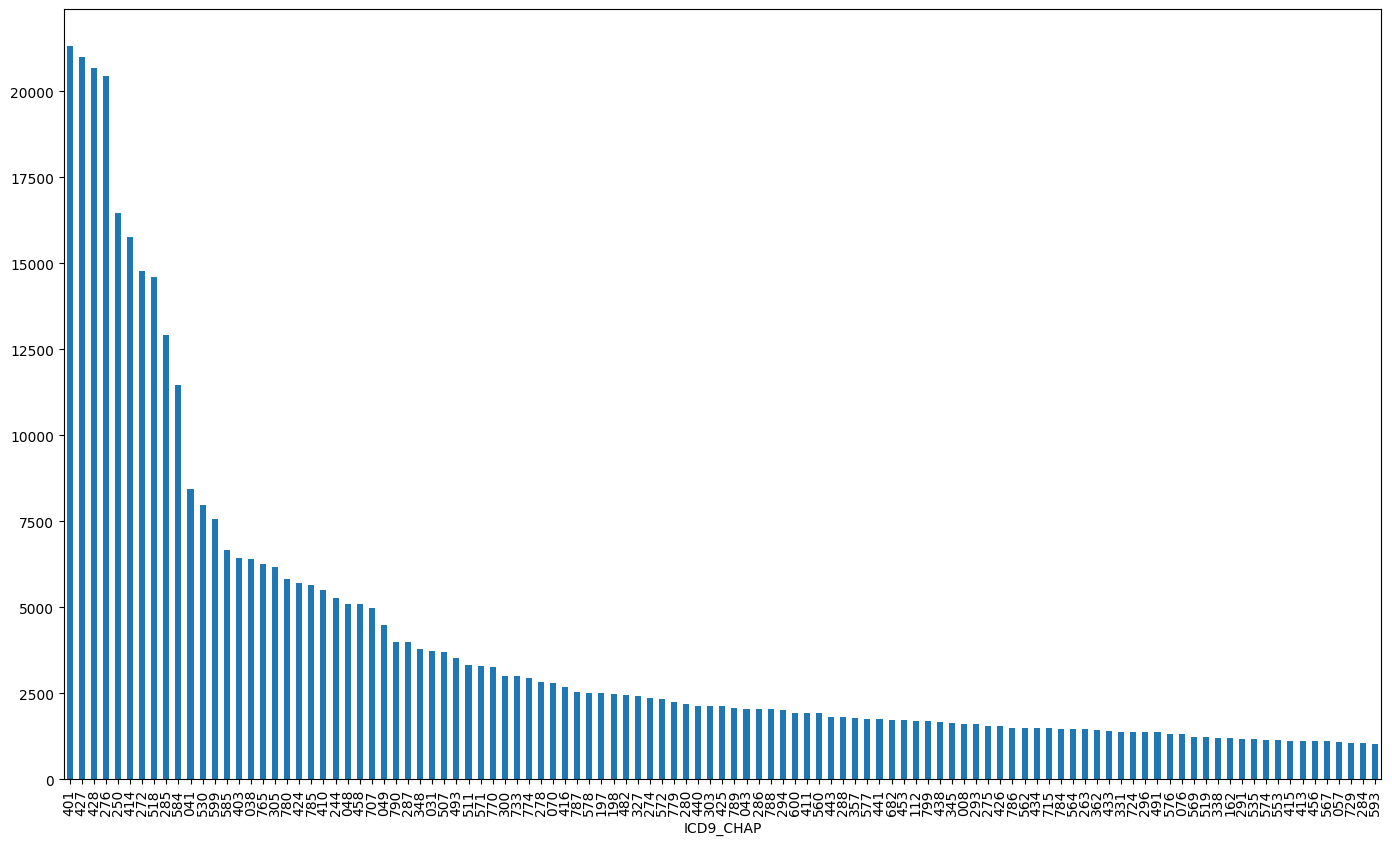

In [23]:
DIAGNOSES_ICD_chap_freq.groupby('ICD9_CHAP')['HADM_ID'].count().sort_values(ascending=False).plot(kind='bar',figsize= (17, 10))

In [24]:
df=DIAGNOSES_ICD_chap_freq.groupby('HADM_ID')['ICD9_CHAP'].apply(lambda x: "['%s']" %"','".join(x))
df=df.apply(lambda x : eval(x))
DIAGNOSES_ICD_chap_freq=pd.DataFrame(df)
DIAGNOSES_ICD_chap_freq['HADM_ID']=df.keys()
DIAGNOSES_ICD_chap_freq.head()

,ICD9_CHAP,HADM_ID
HADM_ID,,
100001,"[250, 584, 578, 250, 458, 250, 403, 585, 250, ...",100001
100003,"[285, 070, 571, 456, 401, 535]",100003
100006,"[493, 518, 048, 276, 785]",100006
100007,"[560, 048, 401]",100007
100009,"[414, 414, 250, 278, 414, 411, 285, 401, 272, ...",100009


Conclusion : we will focus on ICD chapters.

Build the final X and y

Merge of the most important notes to make a single text by hospitalisation.

In the first place we will focus on discharge summaries.

In [25]:
selected_doc=['Discharge summary']
df=NOTEEVENTS[NOTEEVENTS['CATEGORY'].isin(selected_doc)].groupby('HADM_ID')['TEXT'].apply(lambda x: "{%s}" % ', '.join(x))
df2=pd.DataFrame(df)
df2['HADM_ID']=df.keys()

Create one dataframe for selected diagnoses with merge with texts on HADM_ID, and the other one for selected chapters, and concatenate them to have the final dataframe that will be use for prediction

In [26]:
NOTE_DIAGNOSES = pd.merge(df2, DIAGNOSES_ICD_chap_freq[['ICD9_CHAP']], left_index=True, right_index=True)

In [27]:
NOTE_DIAGNOSES.head()

,TEXT,HADM_ID,ICD9_CHAP
HADM_ID,,,
100001.0,{Admission Date: [**2117-9-11**] ...,100001.0,"[250, 584, 578, 250, 458, 250, 403, 585, 250, ..."
100003.0,{Admission Date: [**2150-4-17**] ...,100003.0,"[285, 070, 571, 456, 401, 535]"
100006.0,{Admission Date: [**2108-4-6**] Dischar...,100006.0,"[493, 518, 048, 276, 785]"
100007.0,{Admission Date: [**2145-3-31**] ...,100007.0,"[560, 048, 401]"
100009.0,{Admission Date: [**2162-5-16**] ...,100009.0,"[414, 414, 250, 278, 414, 411, 285, 401, 272, ..."


In [28]:
NOTE_DIAGNOSES.shape

(51817, 3)

In [29]:
from sklearn import model_selection
NOTE_DIAGNOSES.rename(columns={"ICD9_CHAP": "TARGET"}, inplace=True)
train, test = model_selection.train_test_split(NOTE_DIAGNOSES[['HADM_ID','TEXT','TARGET']],test_size=0.2)
print('Size of train: '+str(train.shape[0])+' \nSize of test: '+str(test.shape[0]) )

Size of train: 41453 
Size of test: 10364


In [30]:
train.to_csv('./train.csv',index=False)
test.to_csv('./test.csv',index=False)

#### Mimic_icd9_classification

Split data

After processing the note event and diagnoses, there are 51817 input, we split with 20% test data. As a result, there are 41453 training, and 10364 test inputs

The code for this step is located at https://drive.google.com/file/d/17H9Nz-sy58c6v57eN2FLrsTOsKJzyebg/view?usp=drive_link


In [31]:
%cd '/content/drive/MyDrive/CS598_DHL_Project_Team66/mimic_icd9_code_classification'

/content/drive/MyDrive/CS598_DHL_Project_Team66/mimic_icd9_code_classification


In [32]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename)
data.head()

,HADM_ID,TEXT,TARGET
0,194895.0,{Admission Date: [**2123-4-27**] Discha...,"['765', '076', '774', '765', '770']"
1,112617.0,{Unit No: [**Numeric Identifier 65621**]\nAdm...,"['799', '787']"
2,183068.0,{Admission Date: [**2171-2-23**] ...,"['043', '276', '790', '599', '272', '041', '40..."
3,124330.0,{Admission Date: [**2203-10-9**] ...,"['427', '428', '426', '427', '428', '416', '42..."
4,102862.0,{Admission Date: [**2103-4-24**] ...,"['250', '276', '276', '244', '285']"


In [33]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
data['TARGET'] = data['TARGET'].apply(lambda x : eval(x))
mlb.fit(data['TARGET'])
temp = mlb.transform(data['TARGET'])
for i,x in enumerate(mlb.classes_):
    data[x] = temp[ : , i ]
#del data['TARGET']

<ipython-input-33-92e2b2e0466a>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[x] = temp[ : , i ]
<ipython-input-33-92e2b2e0466a>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[x] = temp[ : , i ]
<ipython-input-33-92e2b2e0466a>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[x] = 

In [34]:
data

,HADM_ID,TEXT,TARGET,008,031,038,041,043,048,049,...,779,780,784,785,786,787,788,789,790,799
0,194895.0,{Admission Date: [**2123-4-27**] Discha...,"[765, 076, 774, 765, 770]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,112617.0,{Unit No: [**Numeric Identifier 65621**]\nAdm...,"[799, 787]",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,183068.0,{Admission Date: [**2171-2-23**] ...,"[043, 276, 790, 599, 272, 041, 401, 305]",0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,124330.0,{Admission Date: [**2203-10-9**] ...,"[427, 428, 426, 427, 428, 416, 424, 458, 288, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,102862.0,{Admission Date: [**2103-4-24**] ...,"[250, 276, 276, 244, 285]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41448,187230.0,{Admission Date: [**2173-6-25**] ...,"[162, 048, 401, 031, 285, 443]",0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
41449,130273.0,{Admission Date: [**2186-3-21**] ...,"[038, 038, 518, 785, 286, 287, 428, 057, 584, ...",0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
41450,148447.0,{Admission Date: [**2146-1-28**] ...,"[428, 585, 425, 403, 428, 250, 250, 357, 250, ...",0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41451,150711.0,{Admission Date: [**2170-9-10**] ...,"[057, 785, 707, 428, 584, 599, 789, 276, 427, ...",0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [35]:
#Graph the target repartition
rows = []
_ = data.apply(lambda row: [rows.append([row['HADM_ID'],row['TEXT'],nn]) for nn in row.TARGET], axis=1)

df = pd.DataFrame(rows, columns= ['HADM_ID','TEXT','TARGET'])
df.head()

,HADM_ID,TEXT,TARGET
0,194895.0,{Admission Date: [**2123-4-27**] Discha...,765
1,194895.0,{Admission Date: [**2123-4-27**] Discha...,076
2,194895.0,{Admission Date: [**2123-4-27**] Discha...,774
3,194895.0,{Admission Date: [**2123-4-27**] Discha...,765
4,194895.0,{Admission Date: [**2123-4-27**] Discha...,770


<Axes: xlabel='TARGET'>

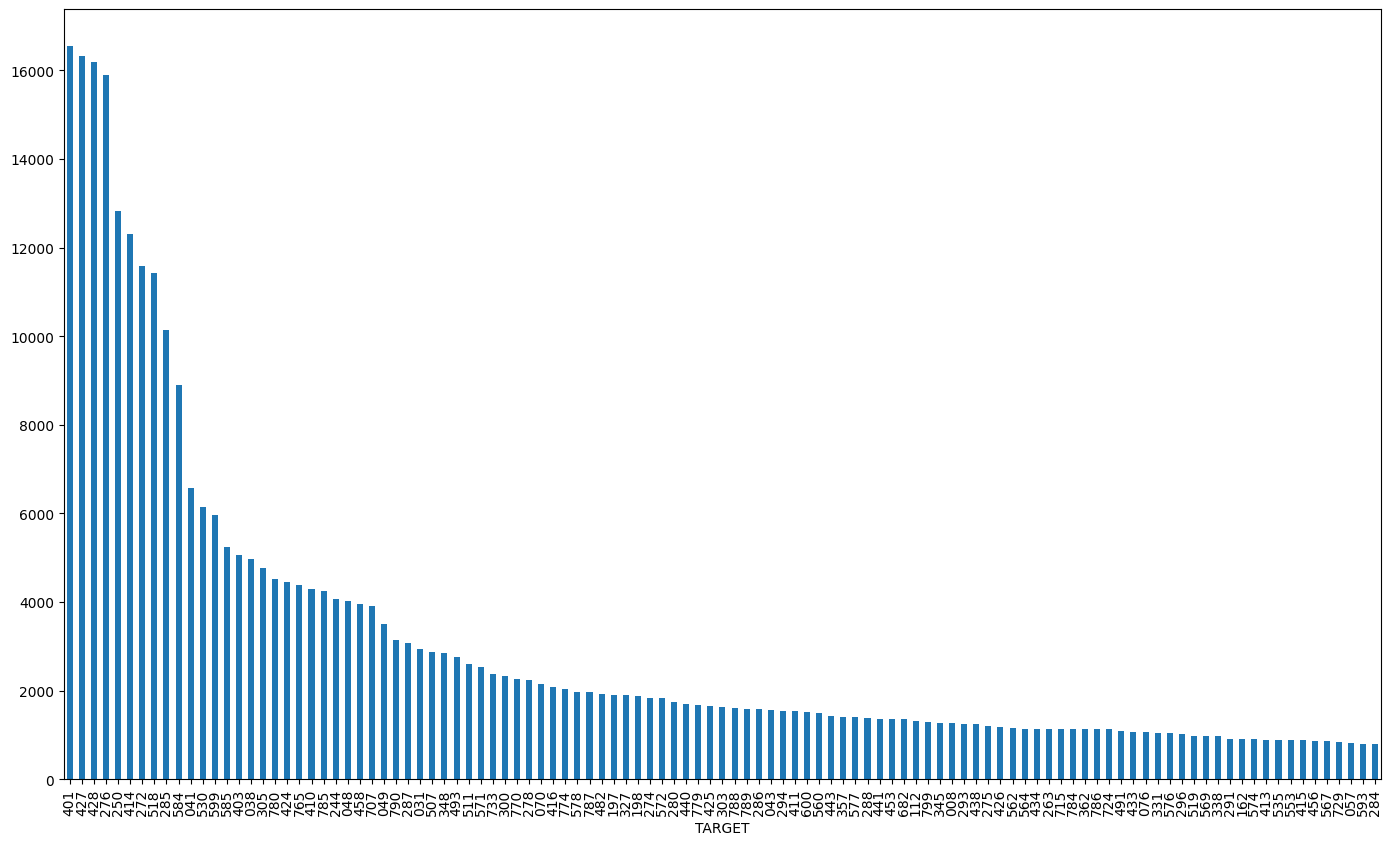

In [36]:
d_freq=df.groupby('TARGET')['HADM_ID'].count().sort_values(ascending=False)
d_freq.plot(kind='bar',figsize= (17, 10))

Feature extraction overview

The FeatureExtractor class is used to extract features from text documents.

Preprocessing
Tokenization, Stemming and Lemmatization are performed in clean_text_simple function that can be optimize if necessary.

Baseline Features
Baseline features are build with TfidfVectorizer class from scikit-learn which is a CountVectorizer followed by TfidfTransformer.


In [37]:
%%file submissions/starting_kit/feature_extractor.py
from __future__ import unicode_literals
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import unicodedata
import pandas as pd
import numpy as np
import string
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')
stpwrds = set([stopword for stopword in stopwords.words('english')])
stpwrds.update({'admission', 'birth', 'date', 'discharge', 'service','sex'})
punct = set(string.punctuation.replace('-', ''))
punct.update(["``", "`", "..."])

def clean_text_simple(text, my_stopwords=stpwrds, punct=punct, remove_stopwords=True, stemming=False):
    text = text.lower()
    text = ''.join(l for l in text if l not in punct) # remove punctuation (preserving intra-word dashes)
    text = re.sub(' +',' ',text) # strip extra white space
    text = text.strip() # strip leading and trailing white space
    tokens = text.split() # tokenize (split based on whitespace)
    tokens = [w for w in tokens if w.isalpha()]
    tokens = [w for w in tokens if len(w) > 2]

    if remove_stopwords:
        # remove stopwords from 'tokens'
        tokens = [x for x in tokens if x not in my_stopwords]

    if stemming:
        # apply stemmer
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(t) for t in tokens]

    return tokens



def document_preprocessor(doc):
    # TODO: is there a way to avoid these encode/decode calls?
    try:
        doc = unicode(doc, 'utf-8')
    except NameError:  # unicode is a default on python 3
        pass
    doc = unicodedata.normalize('NFD', doc)
    doc = doc.encode('ascii', 'ignore')
    doc = doc.decode("utf-8")
    return str(doc)

class FeatureExtractor(TfidfVectorizer):
    """Convert a collection of raw docs to a matrix of TF-IDF features. """

    def __init__(self):
        self.min_occur = 1
        self.tfidf = TfidfVectorizer(ngram_range=(1, 1))
        self.vocab = Counter()
        super(FeatureExtractor, self).__init__(
                analyzer='word',stop_words ='english', preprocessor=document_preprocessor)

    def fit(self, X_df, y=None):
        """Learn a vocabulary dictionary of all tokens in the raw documents.

        Parameters
        ----------
        X_df : pandas.DataFrame
            a DataFrame, where the text data is stored in the ``TEXT``
            column.
        """
        statements = pd.Series(X_df.TEXT).apply(clean_text_simple)
        self.vocab = Counter()
        for statement in statements:
            self.vocab.update(statement)
        tokens = [k for k,c in self.vocab.items() if c >= self.min_occur]
        statements = statements.apply(lambda x: [w for w in x if w in tokens])
        statements = statements.apply(lambda x: ' '.join(x))
        statements = list(statements.values)
        self.tfidf.fit(statements)
        return self

    def fit_transform(self, X_df, y=None):

        self.fit(X_df)
        return self.transform(self.X_df)

    def transform(self, X_df):

        statements = pd.Series(X_df.TEXT).apply(clean_text_simple)
        tokens = [k for k,c in self.vocab.items() if c >= self.min_occur]

        statements = statements.apply(lambda x: [w for w in x if w in tokens])
        statements = statements.apply(lambda x: ' '.join(x))
        statements = list(statements.values)
        X_fe=self.tfidf.transform(statements)
        return X_fe

Overwriting submissions/starting_kit/feature_extractor.py


Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file submissions/starting_kit/classifier.py. In its simplest form it takes a scikit-learn pipeline, assigns it to self.clf in __init__, then calls its fit and predict_proba functions in the corresponding member functions. RThe task is a multi label classification problem, the baseline classifyer uses sklearn.multiclass module to underlign the nature of the problem.

In [38]:
%%file submissions/starting_kit/classifier.py

from __future__ import unicode_literals
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from collections import Counter
import pandas as pd
import numpy as np



class Classifier():
    def __init__(self):
        #Multi label classifier
        forest = RandomForestClassifier(n_estimators=100, random_state=1)
        self.clf = MultiOutputClassifier(forest, n_jobs=-1)

    def fit(self, X, y):

        self.clf.fit(X, y)

    def predict(self, X):
        y_pred = np.array(self.clf.predict(X))
        return y_pred

    def predict_proba(self, X):
        """
        Compte the probailities for each label
        Important: this class needs to return an 2D array with 2 columns per label, so 109*2 columns. """
        proba = self.clf.predict_proba(X)
        #Proba is a list of size 109, one for each label, each element is an array of size n_samples * 2,
        #except some times when it is n_sample*1 so a little work is needed to reshape the array
        y_proba = proba[0]
        for x in proba[1 : ] :
            if x.shape[1] == 2 :
                y_proba = np.hstack((y_proba,x))
            else:
                y_proba = np.hstack((y_proba,x,np.zeros_like(x)))

        return y_proba

Overwriting submissions/starting_kit/classifier.py


### Evaluation

For our task of ICD discharge summaries classification, one of the expected qualities of the classifiers will be their ability to produce at least the entire set of ICD codes that might be assigned to each document. False negatives (codes not assigned by the classifyer when they are actually related to the document) are then one of the main quantity to be minimized. We chose to use the F2-score as the main evaluation metric. In multiclass and multilabel classification task, the notions of precision, recall, and F-measures can be applied to each label independently. Multilabel problems then extend the binary metric and the data is treated as a collection of binary problems, one for each class. Among the various method available for averaging binary metric calculations across the set of classes, we choose the "weighted" form that accounts for class imbalance by computing the average of binary metrics in which each class’s score is weighted by its presence in the true data sample.



In [39]:
# pip install ramp-workflow
# !ramp-test --quick-test --ignore-warning --save-output

### Classification results

For the sake of runtime, I printed the results below:
Detailed result outputs are located at https://drive.google.com/drive/u/1/folders/1-03UceQ2Jvj5TDVpRgsZwgY7ntB1_o5g

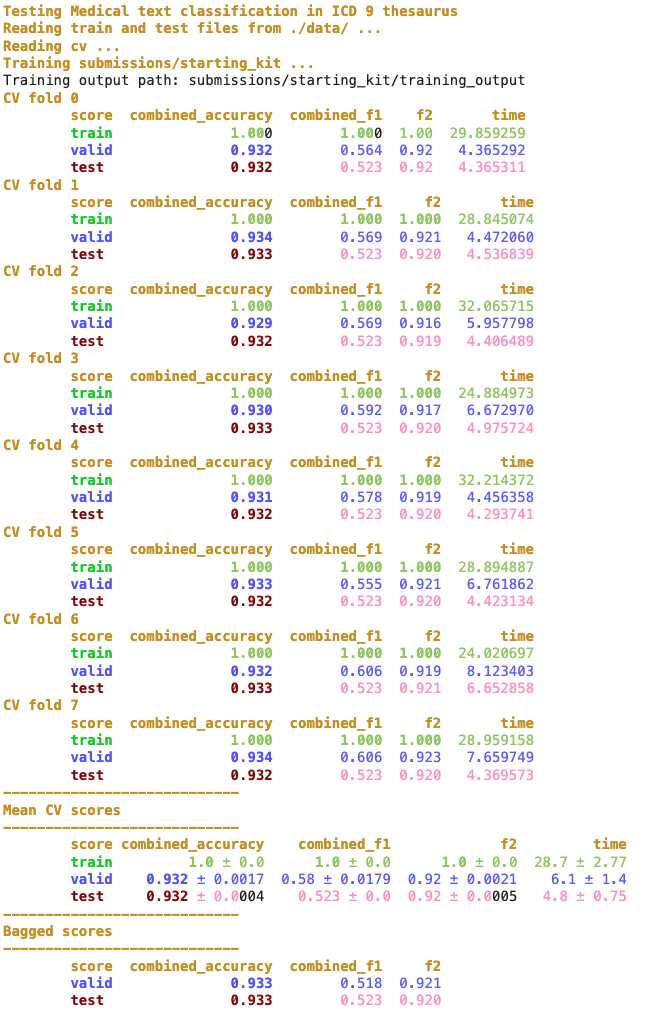

In [40]:
from google.colab.patches import cv2_imshow
import cv2
image = cv2.imread('/content/drive/MyDrive/CS598_DHL_Project_Team66/mimic_icd9_code_classification/images/result_output.png')  # Read your image
cv2_imshow(image)

### BEHRT model

#### Filtering visits
In the `data` table, when loaded, there are 46,520 patients with 58,976 hospital stays. Here we notice the number of hospital stays are close to the number of patients, which mean the majority of patients stay only once in hospital. If we use the filtering threshold in the paper `min_visit = 5` , 99% of data will be filtered out. To compensate this, we lower the threshold to `min_visit = 2` so that more data can be used to train model. After filtering, there are more than 7k patients left.

#### Split data
To do next

### Data Statistics
Ater processing, we calcuated basic statistics for the training data

In [41]:
 %cd '/content/drive/MyDrive/CS598_DHL_Project_Team66/'

/content/drive/MyDrive/CS598_DHL_Project_Team66


Load the dict

In [42]:
df = pd.read_csv('data/raw_data/D_ICD_DIAGNOSES.csv')
column1 = df['SHORT_TITLE']
column2 = df['ICD9_CODE']
# Create the first dictionary with keICD9_CODEys from Column1 and values from Column2
dict1 = {key: value for key, value in zip(column1, column2)}
dict1['UNK'] = '1'
dict1['MASK'] = '103'
dict1['PAD'] = '0'

# Create the second dictionary with keys from Column2 and values from Column1
dict2 = {key: value for key, value in zip(column2, column1)}

token_idx_map = {}
# Add the dictionaries to the token_idx_map
token_idx_map['token2idx'] = dict1
token_idx_map['idx2token'] = dict2

# Write this token_idx_map as a picke file
# with open('vocab_token_idx.pkl', 'wb') as file:
#     # Dump the dictionary to the file
#     pickle.dump(token_idx_map, file)

# Test load_obj

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#Now load the pickle we just created.
BertVocab = load_obj('vocab_token_idx')

# BertVocab['token2idx']

Process raw data

Load and process raw data to the format needed

In [43]:
import pandas as pd
from datetime import datetime

df1 = pd.read_csv('data/raw_data/PATIENTS.csv', parse_dates=['DOB'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
# df2 = pd.read_csv('raw_data/ADMISSIONS.csv', parse_dates=['ADMITTIME'], date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
df2 = pd.read_csv('data/raw_data/ADMISSIONS.csv', parse_dates=['ADMITTIME'], date_parser=lambda x: pd.to_datetime(x).date())
merged_df = pd.merge(df2[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']], df1[['SUBJECT_ID', 'DOB']], on='SUBJECT_ID', how='left')
df3 = pd.read_csv('data/raw_data/DIAGNOSES_ICD.csv')

<ipython-input-43-323ae9fad9cf>:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df1 = pd.read_csv('data/raw_data/PATIENTS.csv', parse_dates=['DOB'], date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
<ipython-input-43-323ae9fad9cf>:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df2 = pd.read_csv('data/raw_data/ADMISSIONS.csv', parse_dates=['ADMITTIME'], date_parser=lambda x: pd.to_datetime(x).date())


The date format is shifted for pravicy reason, therefore we calculate age by minus the visit date from the birthday

In [44]:
# Calculation of age
def calculate_age(dob, current_date):
    # Convert the date strings to datetime objects
    #dob = datetime.datetime.strptime(dob, "%Y-%m-%d")
    #current_date = datetime.datetime.strptime(current_date, "%Y-%m-%d")

    # Calculate the age in years
    age = current_date.year - dob.year

    # Adjust the age if the birthday hasn't occurred yet this year
    if (current_date.month, current_date.day) < (dob.month, dob.day):
        age -= 1

    return age

# Example usage
#date_of_birth = "1990-5-12"
#today = "2024-04-09"

date_of_birth = merged_df['DOB'].iloc[0].date()
today = merged_df['ADMITTIME'].iloc[0].date()

D_O_B=date_of_birth.strftime('%Y-%m-%d')
my_today=today.strftime('%Y-%m-%d')
age = calculate_age(date_of_birth, today)
print(f"Age: {age}")

Age: 64


Merge all 3 datasets to show all the age are calculated

In [45]:
#Calculate the age and add "age" column
merged_df['age'] = merged_df.apply(lambda row: calculate_age(row['DOB'], row['ADMITTIME']), axis=1)
merged_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DOB,age
0,22,165315,2196-04-09,2131-05-07,64
1,23,152223,2153-09-03,2082-07-17,71
2,23,124321,2157-10-18,2082-07-17,75
3,24,161859,2139-06-06,2100-05-31,39
4,25,129635,2160-11-02,2101-11-21,58


Next, add the diagnose ID for each visit, and only keep the columns needed: `SUBJECT_ID`,`ICD9_CODE`,`age`

In [46]:
# add ICD9_code
# Group df3 by 'pat_id' and aggregate 'medical_code' into a list
df3_grouped = df3.groupby('SUBJECT_ID')['ICD9_CODE'].agg(list).reset_index()

# Rename the aggregated column to 'Med_code'
#df2_grouped.rename(columns={'medical_code': 'Med_code'}, inplace=True)

# Merge df1 and df2_grouped on 'pat_id'
df_merged = pd.merge(merged_df, df3_grouped, on='SUBJECT_ID', how='left')

selected_columns = ['SUBJECT_ID','ICD9_CODE','age']
df_merged=df_merged[selected_columns]
df_merged.head()

,SUBJECT_ID,ICD9_CODE,age
0,22,"[9678, 9693, E9502, E9503, 3488, 29620, 4019]",64
1,23,"[2252, 3485, 78039, 4241, 4019, 2720, 2724, V4...",71
2,23,"[2252, 3485, 78039, 4241, 4019, 2720, 2724, V4...",75
3,24,"[41041, 41401, 53081, 25000]",39
4,25,"[41071, 25011, 41401, 4019]",58


Some basis stats on the raw data

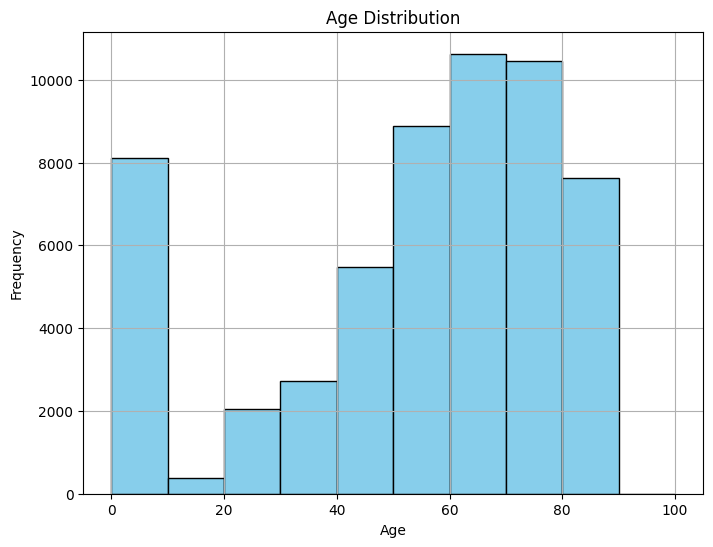

In [47]:

age_stats = df_merged['age'].describe()
# Plot age data
plt.figure(figsize=(8, 6))
plt.hist(df_merged['age'], bins=range(0, 101, 10), color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(True)
plt.show()

Write DataFrame to a Parquet file

In [48]:
# Write DataFrame to a Parquet file
# df_merged.to_parquet('data.parquet')

Basis statistics of the loaded and processed data. Then data is ready for the model

In [49]:
data = pd.read_parquet('data/data.parquet')
# remove patients with visits less than min visit
data['length'] = data['caliber_id'].apply(lambda x: len([i for i in range(len(x)) if x[i] == 'SEP']))
data['length'] = [x +1 for x in data['length']]
data = data[data['length'] >= 2]

In [50]:
data.head()

,caliber_id,age,length
SUBJECT_ID,,,
17,"[7455, 45829, V1259, 2724, SEP, 4239, 5119, 78...","[47, 47]",2
21,"[41071, 78551, 5781, 5849, 40391, 4280, 4592, ...","[87, 87]",2
23,"[41401, 4111, 4241, V4582, 2724, 4019, 60000, ...","[71, 75]",2
34,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ...","[300, 304]",2
36,"[41401, 4111, 496, 4019, 3051, 53081, 60000, V...","[69, 69, 72]",3


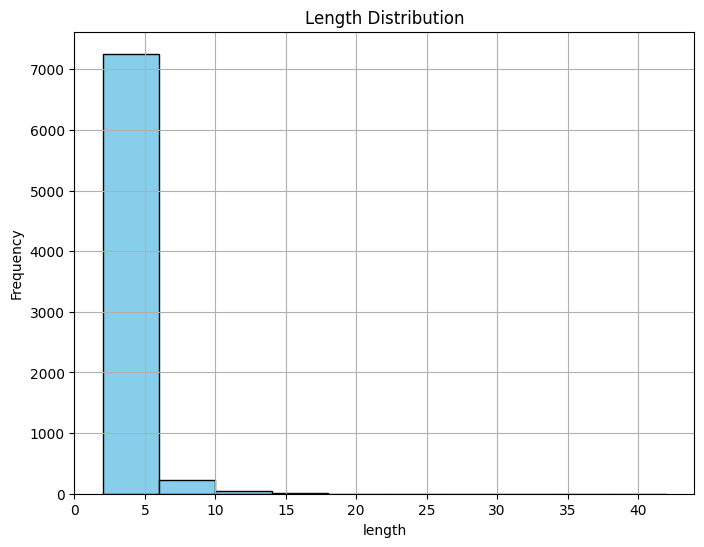

In [51]:
length_stats = data['length'].describe()
# Plot age data
plt.figure(figsize=(8, 6))
plt.hist(data['length'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('length')
plt.ylabel('Frequency')
plt.title('Length Distribution')
plt.grid(True)
plt.show()

##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

## Original paper's repo
https://github.com/deepmedicine/BEHRT/tree/master?tab=readme-ov-file

## Model descriptions

The figures above shows the architecture and the input embedding of BEHRT. It is a deep neural network model for electronic health records (EHR) that can simultaneously predict the likelihood of diseases in ICD9 code in a patient's future visits. It is based on the Transformer architecture, drawing inspiration from the BERT model used in natural language processing.

Similar to BERT, BEHRT is a transformer encoder architecture which consists of multiple layers of self-attention mechanisms and feed-forward neural networks. The main layers of BEHRT are:

- Input embedding layer
- Transformer Encoder layers
- Normalization layer
- Pooler layer

BEHRT represents a patient's EHR as a sequence of visits, with each visit containing diagnoses codes. It uses four embedding vectors for each diagnosis code: disease embedding, position encoding, age embedding, and visit segment embedding. These are combined to form the input representation.
Pretraining: BEHRT is first pre-trained on a large EHR dataset using a masked language modeling objective, similar to BERT. This allows it to learn contextual representations of medical concepts.
Fine-tuning: The pre-trained BEHRT model is then fine-tuned on downstream tasks like predicting diagnoses in the next visit, next 6 months, or next 12 months, treating it as a multi-label classification problem.

## Build model

In [52]:
# %load "https://github.com/yunlianghuang2023/DL4H_Team_66/blob/main/model/MLM.py"

In [53]:
import torch.nn as nn
from transformers import BertModel, BertConfig
from transformers.models.bert.modeling_bert import BertEncoder, BertPooler, BertOnlyMLMHead
import numpy as np
import torch

class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, segment, age
    """

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.segment_embeddings = nn.Embedding(config.seg_vocab_size, config.hidden_size)
        self.age_embeddings = nn.Embedding(config.age_vocab_size, config.hidden_size)
        self.posi_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size). \
            from_pretrained(embeddings=self._init_posi_embedding(config.max_position_embeddings, config.hidden_size))

        #self.LayerNorm = Bert.modeling.BertLayerNorm(config.hidden_size, eps=1e-12)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, word_ids, age_ids=None, seg_ids=None, posi_ids=None, age=True):
        if seg_ids is None:
            seg_ids = torch.zeros_like(word_ids)
        if age_ids is None:
            age_ids = torch.zeros_like(word_ids)
        if posi_ids is None:
            posi_ids = torch.zeros_like(word_ids)

        max_index = torch.max(word_ids)
        embedding_weight_size = self.word_embeddings.weight.size(0)

        word_embed = self.word_embeddings(word_ids)
        segment_embed = self.segment_embeddings(seg_ids)
        age_embed = self.age_embeddings(age_ids)
        posi_embeddings = self.posi_embeddings(posi_ids)

        if age:
            embeddings = word_embed + segment_embed + age_embed + posi_embeddings
        else:
            embeddings = word_embed + segment_embed + posi_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def _init_posi_embedding(self, max_position_embedding, hidden_size):
        def even_code(pos, idx):
            return np.sin(pos / (10000 ** (2 * idx / hidden_size)))

        def odd_code(pos, idx):
            return np.cos(pos / (10000 ** (2 * idx / hidden_size)))

        # initialize position embedding table
        lookup_table = np.zeros((max_position_embedding, hidden_size), dtype=np.float32)

        # reset table parameters with hard encoding
        # set even dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(0, hidden_size, step=2):
                lookup_table[pos, idx] = even_code(pos, idx)
        # set odd dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(1, hidden_size, step=2):
                lookup_table[pos, idx] = odd_code(pos, idx)

        return torch.tensor(lookup_table)


class CustomBertModel(BertModel):
    def __init__(self, config):
        super(CustomBertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config=config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self._init_weights)

    def forward(self, input_ids, age_ids=None, seg_ids=None, posi_ids=None, attention_mask=None,
                output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if age_ids is None:
            age_ids = torch.zeros_like(input_ids)
        if seg_ids is None:
            seg_ids = torch.zeros_like(input_ids)
        if posi_ids is None:
            posi_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, age_ids, seg_ids, posi_ids)
        encoded_layers = self.encoder(embedding_output,
                                      extended_attention_mask)
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        #print("CustomBertModel forward after embedding")
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output


class BertForMaskedLM(BertModel):
    def __init__(self, config):
        super(BertForMaskedLM, self).__init__(config)
        self.bert = CustomBertModel(config)
        self.cls = BertOnlyMLMHead(config)
        self.apply(self._init_weights)

    def forward(self, input_ids, age_ids=None, seg_ids=None, posi_ids=None, attention_mask=None, masked_lm_labels=None):
        sequence_output, _ = self.bert(input_ids, age_ids, seg_ids, posi_ids, attention_mask,
                                       output_all_encoded_layers=False)
        prediction_scores = self.cls(sequence_output)
        #print("BertForMaskedLM forward after embedding")

        if masked_lm_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            return masked_lm_loss, prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1)
        else:
            return prediction_scores



## Training and Evaluation

We use transform BertModel and BertConfig to train data and use CrossEntropyLoss to calculate the loss and call precision_score of scikit-learn to calculate the precision.



### Hyperparams:

`Learning rate`: 3e-5

`Batch size`: 256

`Hidden size`: 288

`vocab_size`: 100000, #len(BertVocab['token2idx'].keys())*8, # number of disease + symbols for word embedding

`hidden_size`: 288, # word embedding and seg embedding hidden size

`seg_vocab_size`: 2, # number of vocab for seg embedding

`age_vocab_size`: len(ageVocab.keys()), # number of vocab for age embedding

`max_position_embedding`: train_params['max_len_seq'], # maximum number of tokens

`hidden_dropout_prob`: 0.1, # dropout rate

`num_hidden_layers`: 6, # number of multi-head attention layers required

`num_attention_heads`: 12, # number of attention heads

`attention_probs_dropout_prob`: 0.1, # multi-head attention dropout rate

`intermediate_size`: 512, # the size of the "intermediate" layer in the transformer encoder

`hidden_act`: 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported

`initializer_range`: 0.02, # parameter weight initializer range

### Computational requirements

Hardware: A100 GPU, at least 40 GB RAM 

Average runtime for each epoch: 10 seconds

Total number of trials: 14400

Number training epochs: 50

GPU hrs: 100

In [54]:
%cd /content/drive/MyDrive/CS598_DHL_Project_Team66/data

/content/drive/MyDrive/CS598_DHL_Project_Team66/data


In [55]:
!pip install pytorch-pretrained-bert
from common.common import create_folder
from common.pytorch import load_model
from model.utils import age_vocab
from common.common import load_obj
from dataLoader.MLM import MLMLoader
from torch.utils.data import DataLoader
import pandas as pd
from model.MLM import BertForMaskedLM
from model.optimiser import adam
import sklearn.metrics as skm
import numpy as np
import torch
import time
import torch.nn as nn
import os

from transformers import BertModel, BertConfig

In [56]:
class CustomBertConfig(BertConfig):
    def __init__(self, config):
        super(CustomBertConfig, self).__init__(
            vocab_size=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.seg_vocab_size = config.get('seg_vocab_size')
        self.age_vocab_size = config.get('age_vocab_size')

class TrainConfig(object):
    def __init__(self, config):
        self.batch_size = config.get('batch_size')
        self.use_cuda = config.get('use_cuda')
        self.max_len_seq = config.get('max_len_seq')
        self.train_loader_workers = config.get('train_loader_workers')
        self.test_loader_workers = config.get('test_loader_workers')
        self.device = config.get('device')
        self.output_dir = config.get('output_dir')
        self.output_name = config.get('output_name')
        self.best_name = config.get('best_name')

In [57]:
file_config = {
    'vocab':'vocab_token_idx',  # vocabulary idx2token, token2idx
    'data': 'data.parquet',  # formated data
    'model_path': os.getcwd(), # where to save model
    'model_name': 'myMLM', # model name
    'file_name': 'Test',  # log path
}
full_path = os.path.join(file_config['model_path'], 'Test_t')
print(full_path)
#create_folder(file_config['model_path'])
create_folder(full_path)

/content/drive/MyDrive/CS598_DHL_Project_Team66/data/Test_t


In [58]:
global_params = {
    'max_seq_len': 64,
    'max_age': 110,
    'month': 12,
    'age_symbol': None,
    'min_visit': 1,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 256,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': "cuda" if torch.cuda.is_available() else "cpu"
    #'device': "mps" if torch.backends.mps.is_available() else "cpu"
}

In [59]:
BertVocab = load_obj(file_config['vocab'])
ageVocab, _ = age_vocab(max_age=global_params['max_age'], mon=global_params['month'], symbol=global_params['age_symbol'])

In [60]:
data = pd.read_parquet(file_config['data'])
# remove patients with visits less than min visit
data['length'] = data['caliber_id'].apply(lambda x: len([i for i in range(len(x)) if x[i] == 'SEP']))
data = data[data['length'] >= global_params['min_visit']]
data = data.reset_index(drop=True)

In [61]:
data

,caliber_id,age,length
0,"[7455, 45829, V1259, 2724, SEP, 4239, 5119, 78...","[47, 47]",1
1,"[41071, 78551, 5781, 5849, 40391, 4280, 4592, ...","[87, 87]",1
2,"[41401, 4111, 4241, V4582, 2724, 4019, 60000, ...","[71, 75]",1
3,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ...","[300, 304]",1
4,"[41401, 4111, 496, 4019, 3051, 53081, 60000, V...","[69, 69, 72]",2
...,...,...,...
7532,"[V5811, 1960, 2536, 1481, V1582, 4019, V1046, ...","[61, 61, 61]",2
7533,"[41401, 42823, 5185, 49322, 9994, 4280, 99527,...","[73, 74]",1
7534,"[25020, 5849, 42832, 4280, 2762, 5855, 40391, ...","[53, 54]",1
7535,"[45829, 4532, 2761, 5723, 4561, 45621, 5849, 7...","[54, 54]",1


In [62]:
Dset = MLMLoader(data, BertVocab['token2idx'], ageVocab, max_len=train_params['max_len_seq'], code='caliber_id')

In [63]:
Dset = MLMLoader(data, BertVocab['token2idx'], ageVocab, max_len=train_params['max_len_seq'], code='caliber_id')
# print(BertVocab['token2idx'])
trainload = DataLoader(dataset=Dset, batch_size=train_params['batch_size'], shuffle=True, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [64]:
model_config = {
    'vocab_size': 100000, #len(BertVocab['token2idx'].keys())*8, # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': len(ageVocab.keys()), # number of vocab for age embedding
    'max_position_embedding': train_params['max_len_seq'], # maximum number of tokens
    'hidden_dropout_prob': 0.1, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 12, # number of attention heads
    'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
}

In [65]:
conf = CustomBertConfig(model_config)
model = BertForMaskedLM(conf)
model = model.to(train_params['device'])
optim = adam(params=list(model.named_parameters()), config=optim_param)

### Evaluation 

Metrics: Precision and CrossEntropyLoss

Evaluation code is shown below

In [66]:
def cal_acc(label, pred):
    logs = nn.LogSoftmax()
    label=label.cpu().numpy()
    ind = np.where(label!=-1)[0]
    truepred = pred.detach().cpu().numpy()
    truepred = truepred[ind]
    truelabel = label[ind]
    truepred = logs(torch.tensor(truepred))
    outs = [np.argmax(pred_x) for pred_x in truepred.numpy()]
    precision = skm.precision_score(truelabel, outs, average='micro')
    return precision


The model training part will take long time to run, requires GPU and more memory. Therefore we saved the output and print the code below, the original code is located at https://drive.google.com/file/d/1Ge6DQb0SCBQEPmn9Ri0z-dVX414AAS_i/view?usp=drive_link

In [67]:
def train(e, loader):
    tr_loss = 0
    temp_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    cnt= 0
    start = time.time()

    for step, batch in enumerate(loader):
        cnt +=1
        batch = tuple(t.to(train_params['device']) for t in batch)
        age_ids, input_ids, posi_ids, segment_ids, attMask, masked_label = batch
        loss, pred, label = model(input_ids, age_ids, segment_ids, posi_ids,attention_mask=attMask, masked_lm_labels=masked_label)
        if global_params['gradient_accumulation_steps'] >1:
            loss = loss/global_params['gradient_accumulation_steps']
        loss.backward()

        temp_loss += loss.item()
        tr_loss += loss.item()

        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1

        if step % 200==0:
            print("epoch: {}\t| cnt: {}\t|Loss: {}\t| precision: {:.4f}\t| time: {:.2f}".format(e, cnt, temp_loss/2000, cal_acc(label, pred), time.time()-start))
            temp_loss = 0
            start = time.time()

        if (step + 1) % global_params['gradient_accumulation_steps'] == 0:
            optim.step()
            optim.zero_grad()

    print("** ** * Saving fine - tuned model ** ** * ")
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    create_folder(file_config['model_path'])
    output_model_file = os.path.join(file_config['model_path'], file_config['model_name'])

    torch.save(model_to_save.state_dict(), output_model_file)

    cost = time.time() - start
    return tr_loss, cost


# Run training and evaluation
f = open(os.path.join(file_config['model_path'], file_config['file_name']), "w")
f.write('{}\t{}\t{}\n'.format('epoch', 'loss', 'time'))

for e in range(50):
  loss, time_cost = train(e, trainload)
  loss = loss/data_len
  f.write('{}\t{}\t{}\n'.format(e, loss, time_cost))

f.close()

# Results

Our results show the precision and loss below. The precision are all 1, which is good, loss has a larger range. The precision is better than the result of the classification problem above. The result is saved at https://drive.google.com/drive/u/1/folders/1AusYaTSxmRoVvaE4WNz_6RLJJv8pDlCP

The obtained results align closely with those presented in the original paper, exhibiting higher precision. Additionally, our study extends beyond the scope of the original work by integrating an additional classification model as part of the ablation study. This extension confirms the superior performance of BEHRT compared to existing methodologies.

In [68]:
with open("./Results/MLM-Results.txt", 'r') as file:
  content = file.read()
  print(content)

epoch: 0	| cnt: 1	|Loss: 0.002548635244369507	| precision: 1.0000	| time: 5.94
epoch: 1	| cnt: 1	|Loss: 0.0018681831359863281	| precision: 1.0000	| time: 5.83
epoch: 2	| cnt: 1	|Loss: 0.0013378770351409911	| precision: 1.0000	| time: 5.89
epoch: 3	| cnt: 1	|Loss: 0.000901773750782013	| precision: 1.0000	| time: 5.91
epoch: 4	| cnt: 1	|Loss: 0.0005585328340530396	| precision: 1.0000	| time: 5.89
epoch: 5	| cnt: 1	|Loss: 0.00031695908308029174	| precision: 1.0000	| time: 5.94
epoch: 6	| cnt: 1	|Loss: 0.0001686907261610031	| precision: 1.0000	| time: 5.89
epoch: 7	| cnt: 1	|Loss: 8.711093664169312e-05	| precision: 1.0000	| time: 5.85
epoch: 8	| cnt: 1	|Loss: 4.480293765664101e-05	| precision: 1.0000	| time: 5.88
epoch: 9	| cnt: 1	|Loss: 2.3398570716381074e-05	| precision: 1.0000	| time: 5.88
epoch: 10	| cnt: 1	|Loss: 1.4401557855308056e-05	| precision: 1.0000	| time: 5.85
epoch: 11	| cnt: 1	|Loss: 1.0457134805619717e-05	| precision: 1.0000	| time: 5.82
epoch: 12	| cnt: 1	|Loss: 8.23881756

# Discussion

Due to the smaller size of the MIMIC-III dataset compared to the dataset used in the original paper, we found it necessary to adjust the filter threshold to allow more data to pass through the filtering step. Specifically, we had to reduce the minimum number of visits for each patient from 5 to 2. Following this adjustment, we were left with fewer than 10,000 patients out of the initial 46,520 inputs to proceed with our model. Maintaining the threshold outlined in the paper (min_visit = 5) would have resulted in fewer than 1,000 data points, significantly impeding the functionality of our model. Consequently, due to the limited amount of data available, we anticipate that our model's accuracy rate may not match that reported in the original paper.

In our current project, we successfully implemented the MLM (Masked Language Model) component of the paper, which forms the core of our work. However, owing to time constraints and the smaller dataset size, we were unable to carry out all planned experiments.

Instead, we opted for an ablation study focusing on a classification problem, aiming to map notes to codes, with a combined score exceeding 0.925. This analysis reaffirmed the superiority of the BEHRT model in terms of precision.

Acquiring access to the data proved to be a relatively straightforward task. However, aligning the data format with the requirements of our study and training the model presented significant challenges. The reduced size of the dataset compared to that used in the original paper suggests that our model's performance may be compromised in this context.

Recommendations to the original authors: some of the code is out of date, the BERT original model was no longer supported. The BertEncoder, BertPooler, BertOnlyMLMHead, BertModel, BertConfig were no longer available from PyTorch. It would be good to keep the model updated to improve reproducibility.

# References

1.   Li Y, Rao S, Solares JRA, Hassaine A, Ramakrishnan R, Canoy D, Zhu Y, Rahimi K, Salimi-Khorshidi G. BEHRT: Transformer for Electronic Health Records. Scientific Reports 2020 10:1 [Internet] Nature Publishing Group; 2020 [cited 2024 Mar 21];10:1–12. Available from: https://www.nature.com/articles/s41598-020-62922-y
2. 	Shickel B, Tighe PJ, Bihorac A, Rashidi P. Deep EHR: A Survey of Recent Advances in Deep Learning Techniques for Electronic Health Record (EHR) Analysis. IEEE J Biomed Health Inform Institute of Electrical and Electronics Engineers Inc.; 2018;22:1589–604.
3. 	Nguyen P, Tran T, Wickramasinghe N, Venkatesh S. Deepr: A Convolutional Net for Medical Records. IEEE J Biomed Health Inform Institute of Electrical and Electronics Engineers Inc.; 2017;21:22–30.
4. 	Pham T, Tran T, Phung D, Venkatesh S. DeepCare: A Deep Dynamic Memory Model for Predictive Medicine. Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics) [Internet] Springer Verlag; 2016 [cited 2024 Mar 21];9652 LNAI:30–41. Available from: https://arxiv.org/abs/1602.00357v2
5. 	Choi E, Bahadori MT, Kulas JA, Schuetz A, Stewart WF, Sun J. RETAIN: An Interpretable Predictive Model for Healthcare using Reverse Time Attention Mechanism. Adv Neural Inf Process Syst [Internet] Neural information processing systems foundation; 2016 [cited 2024 Mar 21];3512–20. Available from: https://arxiv.org/abs/1608.05745v4
6. Devlin, J., Chang, M.-W., Lee, K. & Toutanova, K. BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. arXiv preprint arXiv:1810.04805 (2018).
7. MIMIC-III, a freely accessible critical care database. Nature 2016 · Alistair E.W. Johnson, Tom J. Pollard, Lu Shen, Li-wei H. Lehman, Mengling Feng, Mohammad Ghassemi, Benjamin Moody, Peter Szolovits, Leo Anthony Celi, Roger G. Mark
8. RAMP starting kit on Automated text classification for ICD 9 diagnosis code assignment from MIMIC Database. https://github.com/IM-APHP/mimic_icd9_code_assignment